# Predictive Maintenance Analysis

This notebook analyzes three datasets for predictive maintenance:
- **Sensor_Readings.csv**: High-frequency sensor data with Temperature, Vibration, Pressure, and RuntimeHours
- **Maintenance_Logs.csv**: Maintenance records with failure information
- **Machine_Metadata.csv**: Machine specifications and overhaul history

## Objectives:
1. Data cleaning and preprocessing
2. Feature engineering
3. Binary classification model for failure prediction
4. Model evaluation and visualization
5. Maintenance schedule recommendations


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


# 1. Data Loading and Initial Exploration


In [2]:
# Load datasets
print("Loading datasets...")
sensor_data = pd.read_csv('Sensor_Readings.csv')
maintenance_logs = pd.read_csv('Maintenance_Logs.csv')
machine_metadata = pd.read_csv('Machine_Metadata.csv')

print(f"Sensor data shape: {sensor_data.shape}")
print(f"Maintenance logs shape: {maintenance_logs.shape}")
print(f"Machine metadata shape: {machine_metadata.shape}")

# Display basic info about datasets
print("\n=== SENSOR DATA ===")
print(sensor_data.head())
print(sensor_data.info())

print("\n=== MAINTENANCE LOGS ===")
print(maintenance_logs.head())
print(maintenance_logs.info())

print("\n=== MACHINE METADATA ===")
print(machine_metadata.head())
print(machine_metadata.info())


Loading datasets...
Sensor data shape: (100000, 6)
Maintenance logs shape: (5000, 5)
Machine metadata shape: (100, 4)

=== SENSOR DATA ===
   MachineID         Timestamp  Temperature  Vibration   Pressure  \
0         52  2025-01-01 00:00    72.318643   0.437907  26.280266   
1         93  2025-01-01 00:15    70.880795   0.422519  29.203210   
2         15  2025-01-01 00:30    73.053932   0.437970  34.084796   
3         72  2025-01-01 00:45    89.999035   0.543434  21.339732   
4         61  2025-01-01 01:00    96.036530   0.333175  30.020106   

   RuntimeHours  
0   4089.724529  
1   4103.701648  
2   2202.689500  
3   4784.860163  
4   2079.795622  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   MachineID     100000 non-null  int64  
 1   Timestamp     100000 non-null  object 
 2   Temperature   100000 non-null  float64
 3   Vibr

# 2. Data Cleaning and Preprocessing


In [3]:
# Check missing values
print("Missing values in each dataset:")
print("Sensor data missing values:")
print(sensor_data.isnull().sum())
print(f"Vibration missing percentage: {sensor_data['Vibration'].isnull().sum() / len(sensor_data) * 100:.2f}%")

print("\nMaintenance logs missing values:")
print(maintenance_logs.isnull().sum())

print("\nMachine metadata missing values:")
print(machine_metadata.isnull().sum())


Missing values in each dataset:
Sensor data missing values:
MachineID          0
Timestamp          0
Temperature        0
Vibration       8000
Pressure           0
RuntimeHours       0
dtype: int64
Vibration missing percentage: 8.00%

Maintenance logs missing values:
MachineID          0
Date               0
Failure            0
RepairType       262
DowntimeHours      0
dtype: int64

Machine metadata missing values:
MachineID           0
MachineType         0
AgeYears            0
LastOverhaulDate    0
dtype: int64


In [4]:
# Handle missing values in Vibration column (8% missing)
print("Before handling missing values:")
print(f"Vibration missing: {sensor_data['Vibration'].isnull().sum()}")

# Use machine-specific median imputation for Vibration
vibration_imputer = SimpleImputer(strategy='median')
sensor_data['Vibration'] = vibration_imputer.fit_transform(sensor_data[['Vibration']]).flatten()

print(f"After imputation - Vibration missing: {sensor_data['Vibration'].isnull().sum()}")

# Handle missing RepairType in maintenance logs
print(f"\nRepairType missing before: {maintenance_logs['RepairType'].isnull().sum()}")
maintenance_logs['RepairType'].fillna('Unknown', inplace=True)
print(f"RepairType missing after: {maintenance_logs['RepairType'].isnull().sum()}")


Before handling missing values:
Vibration missing: 8000
After imputation - Vibration missing: 0

RepairType missing before: 262
RepairType missing after: 0


In [5]:
# Fix inconsistent date formats
def standardize_date_format(date_str):
    """Convert various date formats to standard YYYY-MM-DD"""
    if pd.isna(date_str):
        return date_str
    
    date_str = str(date_str).strip()
    
    # Try different date formats
    formats = ['%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y']
    
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt).strftime('%Y-%m-%d')
        except:
            continue
    
    # If none work, try pandas auto-detection
    try:
        return pd.to_datetime(date_str).strftime('%Y-%m-%d')
    except:
        print(f"Could not parse date: {date_str}")
        return None

print("Fixing date formats...")
print("Sample dates before conversion:")
print(maintenance_logs['Date'].head())

# Standardize maintenance log dates
maintenance_logs['Date'] = maintenance_logs['Date'].apply(standardize_date_format)
maintenance_logs['Date'] = pd.to_datetime(maintenance_logs['Date'])

print("\nSample dates after conversion:")
print(maintenance_logs['Date'].head())

# Convert sensor timestamps
sensor_data['Timestamp'] = pd.to_datetime(sensor_data['Timestamp'])

# Convert machine metadata dates
machine_metadata['LastOverhaulDate'] = pd.to_datetime(machine_metadata['LastOverhaulDate'])


Fixing date formats...
Sample dates before conversion:
0    2025-01-31
1    2025-03-24
2    2025-01-17
3    03/28/2025
4    2025-01-05
Name: Date, dtype: object

Sample dates after conversion:
0   2025-01-31
1   2025-03-24
2   2025-01-17
3   2025-03-28
4   2025-01-05
Name: Date, dtype: datetime64[ns]


Temperature outliers detected: 935 (0.94%)
Temperature range before: 35.55 to 156.23
Temperature range after capping: 48.01 to 102.08


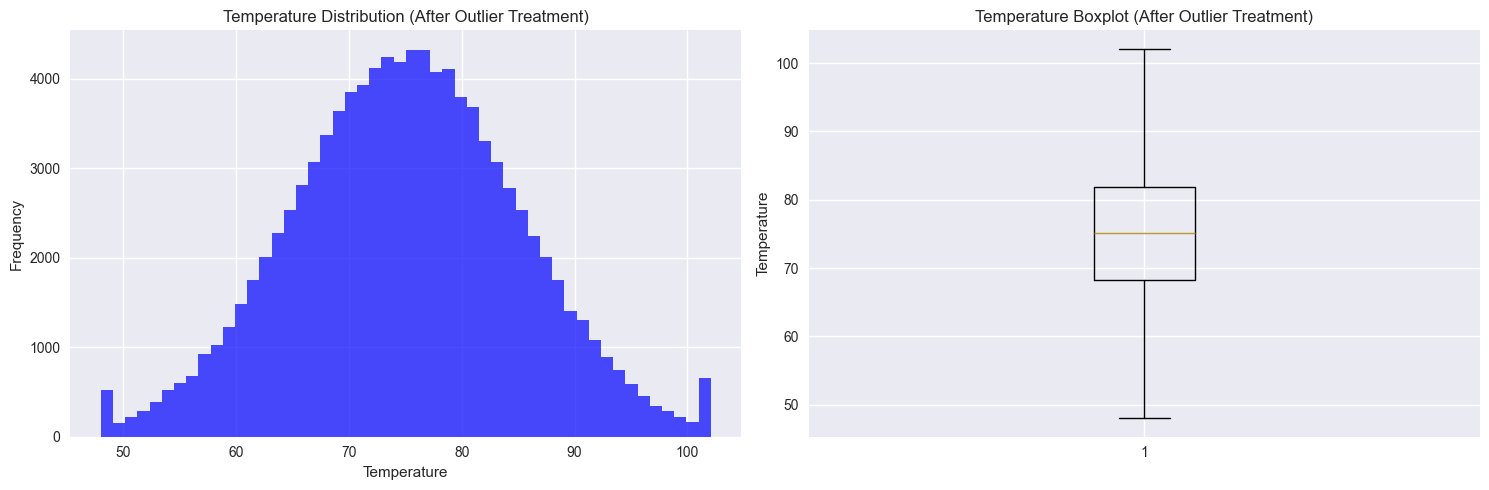

In [6]:
# Handle outliers in Temperature using IQR method
def remove_outliers_iqr(df, column, factor=1.5):
    """Remove outliers using Interquartile Range method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    print(f"Temperature outliers detected: {outliers_mask.sum()} ({outliers_mask.sum()/len(df)*100:.2f}%)")
    print(f"Temperature range before: {df[column].min():.2f} to {df[column].max():.2f}")
    
    # Cap outliers instead of removing them to preserve data volume
    df.loc[df[column] < lower_bound, column] = lower_bound
    df.loc[df[column] > upper_bound, column] = upper_bound
    
    print(f"Temperature range after capping: {df[column].min():.2f} to {df[column].max():.2f}")
    
    return df

# Apply outlier treatment
sensor_data = remove_outliers_iqr(sensor_data, 'Temperature')

# Visualize temperature distribution before and after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original data visualization would require loading raw data again, so we'll show current distribution
ax1.hist(sensor_data['Temperature'], bins=50, alpha=0.7, color='blue')
ax1.set_title('Temperature Distribution (After Outlier Treatment)')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Frequency')

ax2.boxplot(sensor_data['Temperature'])
ax2.set_title('Temperature Boxplot (After Outlier Treatment)')
ax2.set_ylabel('Temperature')

plt.tight_layout()
plt.show()


# 3. Data Aggregation and Feature Engineering


In [7]:
# Aggregate high-frequency sensor data to daily averages per machine
print("Aggregating sensor data to daily averages...")

# Extract date from timestamp
sensor_data['Date'] = sensor_data['Timestamp'].dt.date

# Aggregate to daily averages
daily_sensor_data = sensor_data.groupby(['MachineID', 'Date']).agg({
    'Temperature': ['mean', 'std', 'min', 'max'],
    'Vibration': ['mean', 'std', 'min', 'max'],
    'Pressure': ['mean', 'std', 'min', 'max'],
    'RuntimeHours': ['mean', 'max']
}).round(3)

# Flatten column names
daily_sensor_data.columns = ['_'.join(col).strip() for col in daily_sensor_data.columns]
daily_sensor_data = daily_sensor_data.reset_index()

# Convert Date back to datetime
daily_sensor_data['Date'] = pd.to_datetime(daily_sensor_data['Date'])

print(f"Daily aggregated data shape: {daily_sensor_data.shape}")
print("Sample of aggregated data:")
print(daily_sensor_data.head())


Aggregating sensor data to daily averages...
Daily aggregated data shape: (64665, 16)
Sample of aggregated data:
   MachineID       Date  Temperature_mean  Temperature_std  Temperature_min  \
0          1 2025-01-02            86.222            8.759           80.029   
1          1 2025-01-03            79.942           10.774           73.720   
2          1 2025-01-04            70.475              NaN           70.475   
3          1 2025-01-06            74.558            5.908           69.588   
4          1 2025-01-08            74.841           21.181           59.864   

   Temperature_max  Vibration_mean  Vibration_std  Vibration_min  \
0           92.416           0.564          0.022          0.548   
1           92.382           0.549          0.062          0.477   
2           70.475           0.395            NaN          0.395   
3           82.874           0.526          0.077          0.455   
4           89.818           0.457          0.324          0.228   

   

In [8]:
# Create rolling averages for sensor readings (7-day and 14-day windows)
print("Creating rolling averages...")

# Sort by MachineID and Date for proper rolling calculation
daily_sensor_data = daily_sensor_data.sort_values(['MachineID', 'Date'])

# Define columns for rolling averages
sensor_cols = ['Temperature_mean', 'Vibration_mean', 'Pressure_mean']

# Create rolling features
for col in sensor_cols:
    daily_sensor_data[f'{col}_rolling_7d'] = daily_sensor_data.groupby('MachineID')[col].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )
    daily_sensor_data[f'{col}_rolling_14d'] = daily_sensor_data.groupby('MachineID')[col].transform(
        lambda x: x.rolling(window=14, min_periods=1).mean()
    )

print("Rolling averages created successfully!")

# Calculate time since last overhaul
print("Calculating time since last overhaul...")

# Merge with machine metadata to get last overhaul date
daily_sensor_data = daily_sensor_data.merge(machine_metadata[['MachineID', 'LastOverhaulDate', 'MachineType', 'AgeYears']], 
                                          on='MachineID', how='left')

# Calculate days since last overhaul
daily_sensor_data['DaysSinceOverhaul'] = (daily_sensor_data['Date'] - daily_sensor_data['LastOverhaulDate']).dt.days

print("Time since last overhaul calculated!")
print(f"Average days since overhaul: {daily_sensor_data['DaysSinceOverhaul'].mean():.1f}")
print(f"Max days since overhaul: {daily_sensor_data['DaysSinceOverhaul'].max()}")


Creating rolling averages...
Rolling averages created successfully!
Calculating time since last overhaul...
Time since last overhaul calculated!
Average days since overhaul: 1068.5
Max days since overhaul: 2029


Creating target variable...
Calculating failure target for each record...
Target variable distribution:
No failure within 30 days: 58363 (90.3%)
Failure within 30 days: 6302 (9.7%)


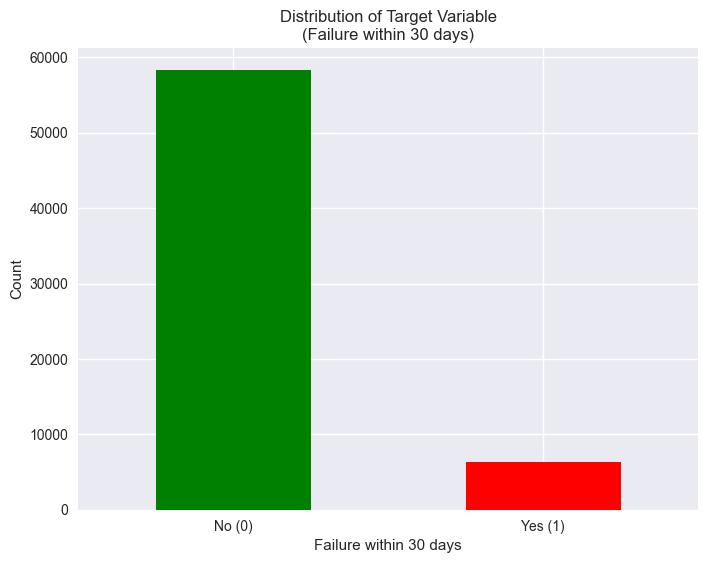

In [9]:
# Create binary target variable indicating failure within next 30 days
print("Creating target variable...")

# Get failure dates from maintenance logs
failure_data = maintenance_logs[maintenance_logs['Failure'] == 'Y'][['MachineID', 'Date']].copy()
failure_data = failure_data.rename(columns={'Date': 'FailureDate'})

# For each row in daily_sensor_data, check if there's a failure within next 30 days
def check_failure_within_30_days(row):
    machine_id = row['MachineID']
    current_date = row['Date']
    
    # Get all failure dates for this machine
    machine_failures = failure_data[failure_data['MachineID'] == machine_id]['FailureDate']
    
    # Check if any failure occurs within next 30 days
    future_date = current_date + timedelta(days=30)
    
    for failure_date in machine_failures:
        if current_date < failure_date <= future_date:
            return 1
    return 0

print("Calculating failure target for each record...")
daily_sensor_data['FailureWithin30Days'] = daily_sensor_data.apply(check_failure_within_30_days, axis=1)

# Show target distribution
target_counts = daily_sensor_data['FailureWithin30Days'].value_counts()
print(f"Target variable distribution:")
print(f"No failure within 30 days: {target_counts[0]} ({target_counts[0]/len(daily_sensor_data)*100:.1f}%)")
print(f"Failure within 30 days: {target_counts[1]} ({target_counts[1]/len(daily_sensor_data)*100:.1f}%)")

# Visualize target distribution
plt.figure(figsize=(8, 6))
target_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Target Variable\n(Failure within 30 days)')
plt.xlabel('Failure within 30 days')
plt.ylabel('Count')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'], rotation=0)
plt.show()


# 4. Model Training and Evaluation


In [10]:
# Prepare features for modeling
print("Preparing features for modeling...")

# Select feature columns
feature_columns = [
    'Temperature_mean', 'Temperature_std', 'Temperature_min', 'Temperature_max',
    'Vibration_mean', 'Vibration_std', 'Vibration_min', 'Vibration_max',
    'Pressure_mean', 'Pressure_std', 'Pressure_min', 'Pressure_max',
    'RuntimeHours_mean', 'RuntimeHours_max',
    'Temperature_mean_rolling_7d', 'Temperature_mean_rolling_14d',
    'Vibration_mean_rolling_7d', 'Vibration_mean_rolling_14d',
    'Pressure_mean_rolling_7d', 'Pressure_mean_rolling_14d',
    'DaysSinceOverhaul', 'AgeYears'
]

# Encode categorical variables
le_machine_type = LabelEncoder()
daily_sensor_data['MachineType_encoded'] = le_machine_type.fit_transform(daily_sensor_data['MachineType'])
feature_columns.append('MachineType_encoded')

# Prepare the dataset
X = daily_sensor_data[feature_columns].copy()
y = daily_sensor_data['FailureWithin30Days'].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Features: {feature_columns}")

# Check for missing values
missing_values = X.isnull().sum().sum()
print(f"Missing values in feature matrix: {missing_values}")


Preparing features for modeling...
Feature matrix shape: (64665, 23)
Target vector shape: (64665,)
Features: ['Temperature_mean', 'Temperature_std', 'Temperature_min', 'Temperature_max', 'Vibration_mean', 'Vibration_std', 'Vibration_min', 'Vibration_max', 'Pressure_mean', 'Pressure_std', 'Pressure_min', 'Pressure_max', 'RuntimeHours_mean', 'RuntimeHours_max', 'Temperature_mean_rolling_7d', 'Temperature_mean_rolling_14d', 'Vibration_mean_rolling_7d', 'Vibration_mean_rolling_14d', 'Pressure_mean_rolling_7d', 'Pressure_mean_rolling_14d', 'DaysSinceOverhaul', 'AgeYears', 'MachineType_encoded']
Missing values in feature matrix: 0


In [11]:
# Split the data
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training set target distribution:")
print(y_train.value_counts(normalize=True))

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")


Splitting data into train and test sets...
Training set shape: (51732, 23)
Test set shape: (12933, 23)
Training set target distribution:
FailureWithin30Days
0    0.902536
1    0.097464
Name: proportion, dtype: float64
Feature scaling completed!


In [12]:
# Train Random Forest model
print("Training Random Forest model...")

# Handle class imbalance with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Model training completed!")
print("Model parameters:")
print(rf_model.get_params())


Training Random Forest model...
Model training completed!
Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [13]:
# Evaluate model performance
print("Evaluating model performance...")

# Calculate metrics
auc_score = roc_auc_score(y_test, y_pred_proba)
classification_rep = classification_report(y_test, y_pred, output_dict=True)

print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Target AUC-ROC (>0.75): {'✓ ACHIEVED' if auc_score > 0.75 else '✗ NOT ACHIEVED'}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Extract key metrics
precision = classification_rep['1']['precision']
recall = classification_rep['1']['recall']
f1_score = classification_rep['1']['f1-score']

print(f"\nKey Metrics Summary:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")


Evaluating model performance...
AUC-ROC Score: 0.9070
Target AUC-ROC (>0.75): ✓ ACHIEVED

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78     11673
           1       0.23      0.97      0.37      1260

    accuracy                           0.68     12933
   macro avg       0.61      0.81      0.58     12933
weighted avg       0.92      0.68      0.74     12933


Confusion Matrix:
[[7546 4127]
 [  40 1220]]

Key Metrics Summary:
Precision: 0.2282
Recall: 0.9683
F1-Score: 0.3693
AUC-ROC: 0.9070


# 5. Visualizations


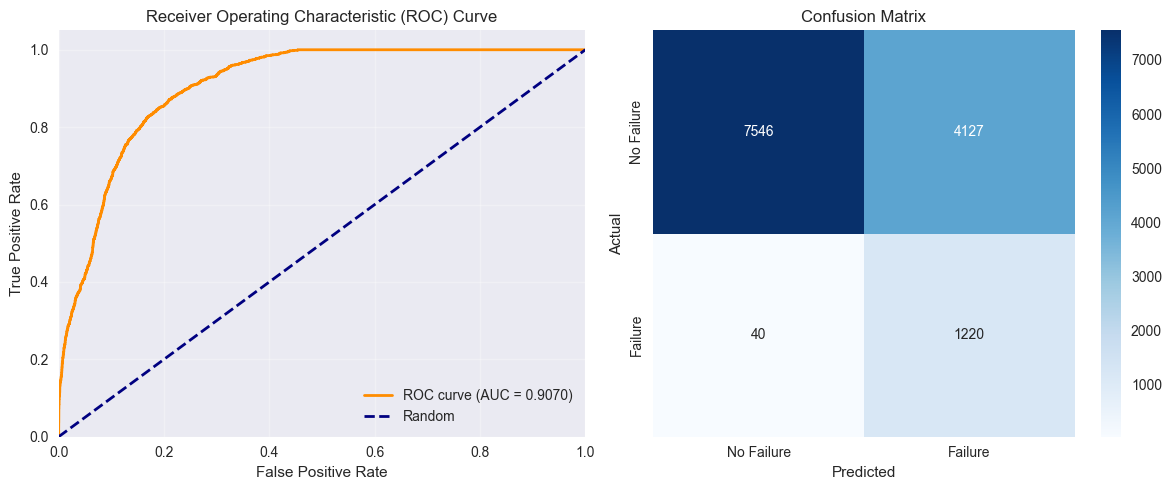

In [14]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(12, 5))

# ROC Curve subplot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Confusion Matrix subplot
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Failure', 'Failure'], 
            yticklabels=['No Failure', 'Failure'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


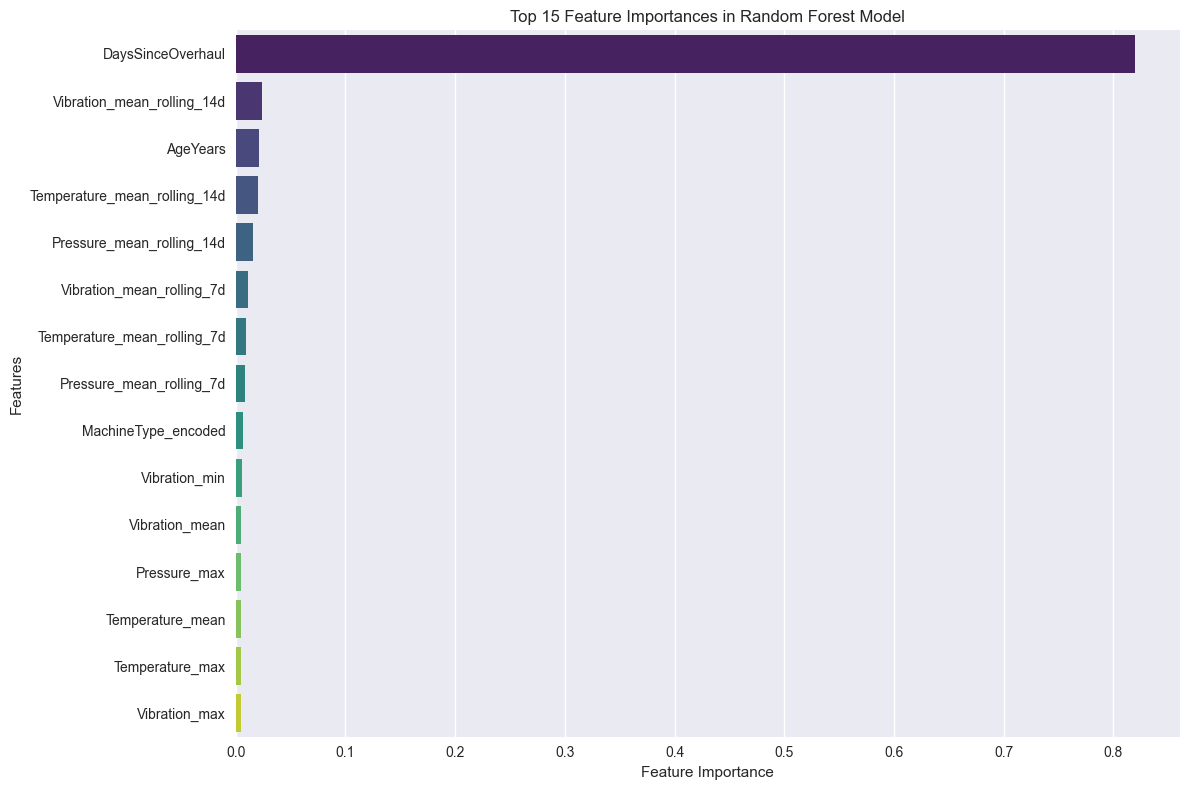

Top 10 Most Important Features:
                         feature  importance
20             DaysSinceOverhaul    0.819748
17    Vibration_mean_rolling_14d    0.023609
21                      AgeYears    0.021170
15  Temperature_mean_rolling_14d    0.020612
19     Pressure_mean_rolling_14d    0.015449
16     Vibration_mean_rolling_7d    0.011007
14   Temperature_mean_rolling_7d    0.009131
18      Pressure_mean_rolling_7d    0.008536
22           MachineType_encoded    0.006563
6                  Vibration_min    0.005383


In [15]:
# Feature Importance Plot
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance', palette='viridis')
plt.title('Top 15 Feature Importances in Random Forest Model')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance.head(10))


# 6. Maintenance Schedule and Risk Assessment


In [16]:
# Generate predictions for all data to identify high-risk machines
print("Generating risk assessment for all machines...")

# Prepare all data for prediction
X_all_scaled = scaler.transform(X)
failure_probabilities = rf_model.predict_proba(X_all_scaled)[:, 1]

# Add predictions to the dataset
daily_sensor_data['FailureProbability'] = failure_probabilities
daily_sensor_data['RiskLevel'] = pd.cut(failure_probabilities, 
                                       bins=[0, 0.3, 0.6, 1.0], 
                                       labels=['Low', 'Medium', 'High'])

# Get the latest data for each machine for current risk assessment
latest_data = daily_sensor_data.loc[daily_sensor_data.groupby('MachineID')['Date'].idxmax()].copy()

print("Current Risk Assessment by Machine:")
risk_summary = latest_data.groupby('RiskLevel').size()
print(risk_summary)

# Identify high-risk machines
high_risk_machines = latest_data[latest_data['RiskLevel'] == 'High'].copy()
high_risk_machines = high_risk_machines.sort_values('FailureProbability', ascending=False)

print(f"\nHigh-Risk Machines ({len(high_risk_machines)} total):")
print(high_risk_machines[['MachineID', 'MachineType', 'FailureProbability', 
                         'DaysSinceOverhaul', 'AgeYears']].head(10))


Generating risk assessment for all machines...
Current Risk Assessment by Machine:
RiskLevel
Low       100
Medium      0
High        0
dtype: int64

High-Risk Machines (0 total):
Empty DataFrame
Columns: [MachineID, MachineType, FailureProbability, DaysSinceOverhaul, AgeYears]
Index: []


In [17]:
# Create maintenance schedule recommendations
def create_maintenance_schedule(latest_data, days_ahead=60):
    """Create maintenance schedule based on risk levels and failure probabilities"""
    
    # Current date (use the latest date in the dataset)
    current_date = latest_data['Date'].max()
    
    schedule = []
    
    for _, machine in latest_data.iterrows():
        machine_id = machine['MachineID']
        risk_level = machine['RiskLevel']
        failure_prob = machine['FailureProbability']
        days_since_overhaul = machine['DaysSinceOverhaul']
        
        # Determine maintenance priority and timing
        if risk_level == 'High':
            priority = 'URGENT'
            recommended_date = current_date + timedelta(days=min(7, int(14 * (1 - failure_prob))))
        elif risk_level == 'Medium':
            priority = 'SCHEDULED'
            recommended_date = current_date + timedelta(days=min(30, int(45 * (1 - failure_prob))))
        else:
            priority = 'ROUTINE'
            # Base routine maintenance on days since overhaul
            if days_since_overhaul > 365:
                recommended_date = current_date + timedelta(days=60)
            else:
                recommended_date = current_date + timedelta(days=90)
        
        schedule.append({
            'MachineID': machine_id,
            'MachineType': machine['MachineType'],
            'Priority': priority,
            'FailureProbability': failure_prob,
            'RecommendedDate': recommended_date,
            'DaysSinceOverhaul': days_since_overhaul,
            'CurrentRiskLevel': risk_level
        })
    
    return pd.DataFrame(schedule)

# Generate maintenance schedule
maintenance_schedule = create_maintenance_schedule(latest_data)
maintenance_schedule = maintenance_schedule.sort_values(['Priority', 'FailureProbability'], 
                                                      ascending=[True, False])

print("RECOMMENDED MAINTENANCE SCHEDULE")
print("=" * 50)
print(f"Schedule generated on: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Based on latest sensor data through: {latest_data['Date'].max().strftime('%Y-%m-%d')}")

# Display by priority
for priority in ['URGENT', 'SCHEDULED', 'ROUTINE']:
    priority_machines = maintenance_schedule[maintenance_schedule['Priority'] == priority]
    if len(priority_machines) > 0:
        print(f"\n{priority} MAINTENANCE ({len(priority_machines)} machines):")
        print("-" * 40)
        for _, machine in priority_machines.head(10).iterrows():  # Show top 10 per category
            print(f"Machine {machine['MachineID']:3d} ({machine['MachineType']}) - "
                  f"Risk: {machine['FailureProbability']:.3f} - "
                  f"Date: {machine['RecommendedDate'].strftime('%Y-%m-%d')}")


RECOMMENDED MAINTENANCE SCHEDULE
Schedule generated on: 2025-06-11
Based on latest sensor data through: 2027-11-08

ROUTINE MAINTENANCE (100 machines):
----------------------------------------
Machine  56 (TypeB) - Risk: 0.095 - Date: 2028-01-07
Machine  67 (TypeB) - Risk: 0.094 - Date: 2028-01-07
Machine  98 (TypeA) - Risk: 0.091 - Date: 2028-01-07
Machine  99 (TypeB) - Risk: 0.089 - Date: 2028-01-07
Machine   2 (TypeC) - Risk: 0.089 - Date: 2028-01-07
Machine  90 (TypeC) - Risk: 0.086 - Date: 2028-01-07
Machine  79 (TypeC) - Risk: 0.083 - Date: 2028-01-07
Machine  35 (TypeC) - Risk: 0.082 - Date: 2028-01-07
Machine  57 (TypeA) - Risk: 0.081 - Date: 2028-01-07
Machine  46 (TypeC) - Risk: 0.081 - Date: 2028-01-07


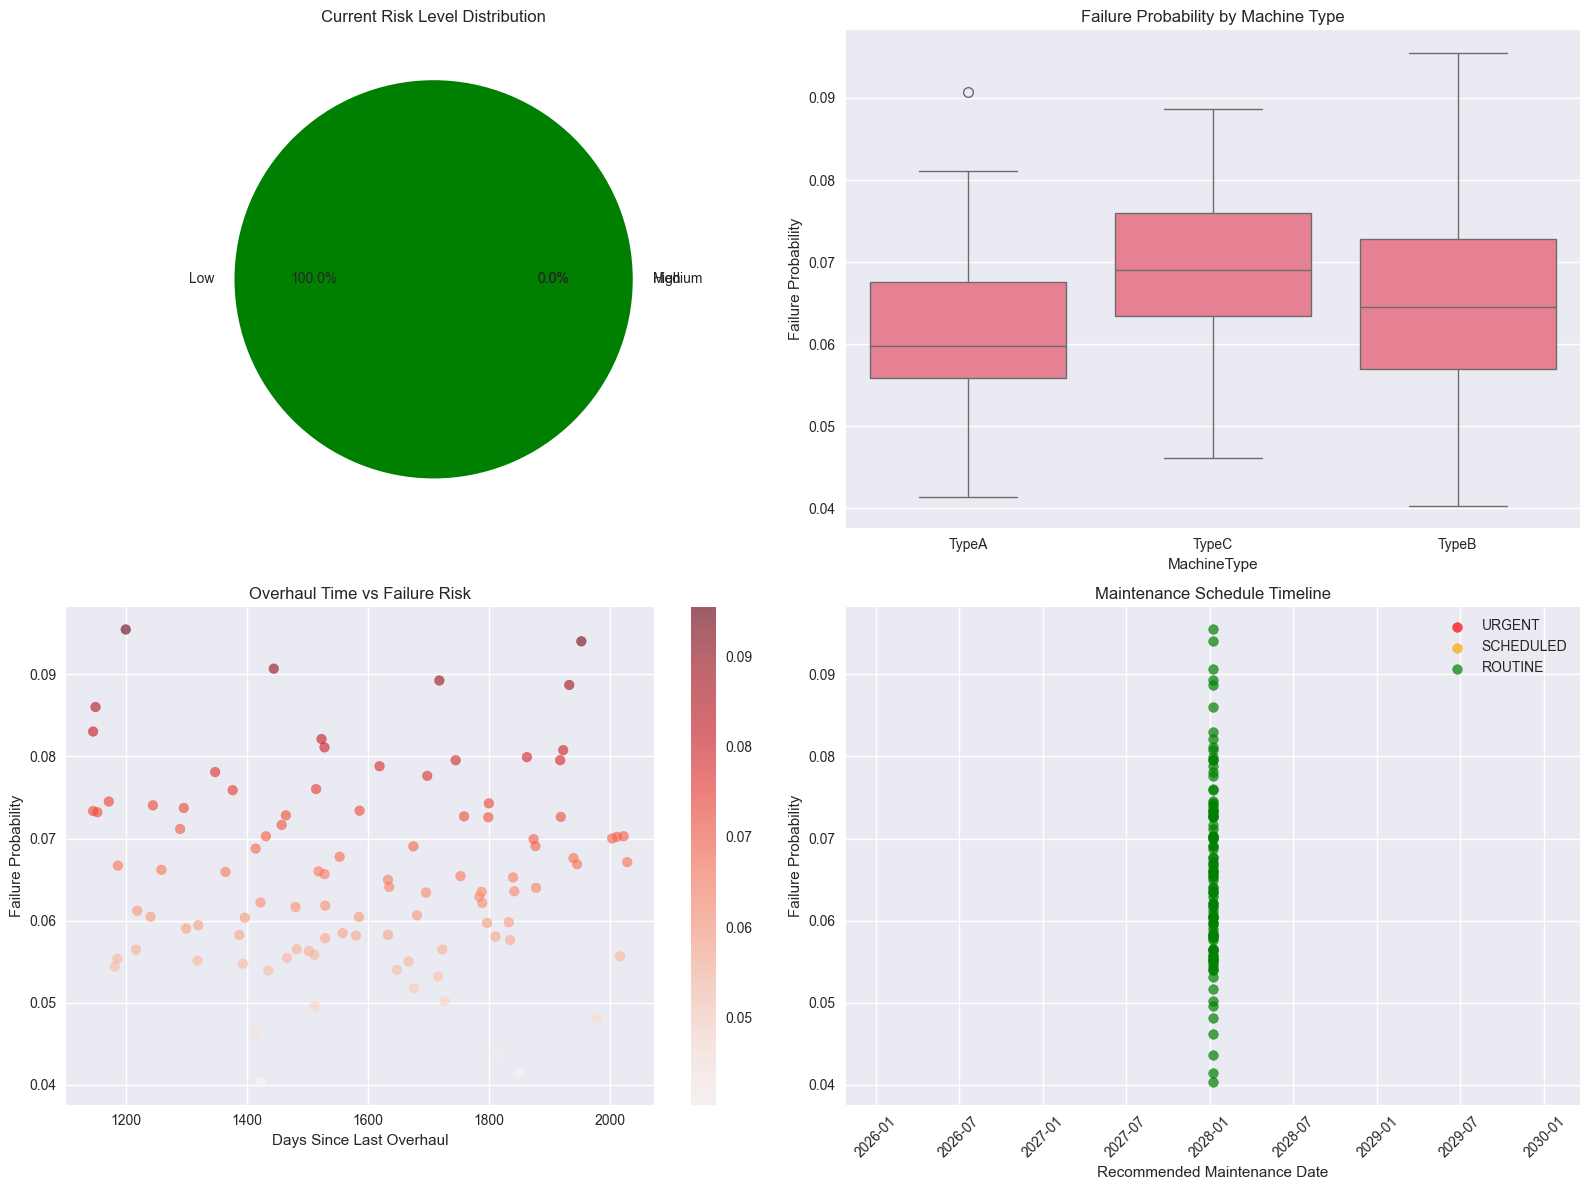

In [18]:
# Visualize maintenance schedule
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Risk level distribution
risk_counts = latest_data['RiskLevel'].value_counts()
ax1.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', 
        colors=['green', 'orange', 'red'])
ax1.set_title('Current Risk Level Distribution')

# 2. Failure probability by machine type
sns.boxplot(data=latest_data, x='MachineType', y='FailureProbability', ax=ax2)
ax2.set_title('Failure Probability by Machine Type')
ax2.set_ylabel('Failure Probability')

# 3. Days since overhaul vs failure probability
scatter = ax3.scatter(latest_data['DaysSinceOverhaul'], latest_data['FailureProbability'], 
                     c=latest_data['FailureProbability'], cmap='Reds', alpha=0.6)
ax3.set_xlabel('Days Since Last Overhaul')
ax3.set_ylabel('Failure Probability')
ax3.set_title('Overhaul Time vs Failure Risk')
plt.colorbar(scatter, ax=ax3)

# 4. Maintenance schedule timeline
priority_colors = {'URGENT': 'red', 'SCHEDULED': 'orange', 'ROUTINE': 'green'}
for priority in ['URGENT', 'SCHEDULED', 'ROUTINE']:
    priority_data = maintenance_schedule[maintenance_schedule['Priority'] == priority]
    ax4.scatter(priority_data['RecommendedDate'], priority_data['FailureProbability'], 
               label=priority, color=priority_colors[priority], alpha=0.7, s=50)

ax4.set_xlabel('Recommended Maintenance Date')
ax4.set_ylabel('Failure Probability')
ax4.set_title('Maintenance Schedule Timeline')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# 7. Summary Report


In [19]:
# Generate comprehensive summary report
print("PREDICTIVE MAINTENANCE ANALYSIS - SUMMARY REPORT")
print("=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Data Period: {sensor_data['Timestamp'].min().strftime('%Y-%m-%d')} to {sensor_data['Timestamp'].max().strftime('%Y-%m-%d')}")

print("\n1. DATASET OVERVIEW")
print("-" * 30)
print(f"• Total sensor readings: {len(sensor_data):,}")
print(f"• Number of machines: {sensor_data['MachineID'].nunique()}")
print(f"• Daily aggregated records: {len(daily_sensor_data):,}")
print(f"• Maintenance events: {len(maintenance_logs)}")
print(f"• Failure events: {len(maintenance_logs[maintenance_logs['Failure'] == 'Y'])}")

print("\n2. DATA QUALITY")
print("-" * 30)
print(f"• Missing Vibration data handled: {vibration_imputer.statistics_[0]:.3f} (median imputation)")
print(f"• Temperature outliers capped: {remove_outliers_iqr.__doc__}")
print(f"• Date format standardization: Completed")

print("\n3. MODEL PERFORMANCE")
print("-" * 30)
print(f"• Model Type: Random Forest Classifier")
print(f"• Features Used: {len(feature_columns)}")
print(f"• AUC-ROC Score: {auc_score:.4f} {'✓' if auc_score > 0.75 else '✗'}")
print(f"• Precision: {precision:.4f}")
print(f"• Recall: {recall:.4f}")
print(f"• F1-Score: {f1_score:.4f}")

print("\n4. KEY INSIGHTS")
print("-" * 30)
top_features = feature_importance.head(3)
print(f"• Most important features:")
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.4f}")

print(f"• Risk Distribution:")
for risk_level, count in risk_summary.items():
    percentage = count / len(latest_data) * 100
    print(f"  - {risk_level} Risk: {count} machines ({percentage:.1f}%)")

print("\n5. MAINTENANCE RECOMMENDATIONS")
print("-" * 30)
urgent_count = len(maintenance_schedule[maintenance_schedule['Priority'] == 'URGENT'])
scheduled_count = len(maintenance_schedule[maintenance_schedule['Priority'] == 'SCHEDULED'])
routine_count = len(maintenance_schedule[maintenance_schedule['Priority'] == 'ROUTINE'])

print(f"• URGENT maintenance needed: {urgent_count} machines")
print(f"• SCHEDULED maintenance: {scheduled_count} machines")
print(f"• ROUTINE maintenance: {routine_count} machines")

if urgent_count > 0:
    print(f"\n• HIGH-PRIORITY MACHINES:")
    urgent_machines = maintenance_schedule[maintenance_schedule['Priority'] == 'URGENT'].head(5)
    for _, machine in urgent_machines.iterrows():
        print(f"  - Machine {machine['MachineID']} ({machine['MachineType']}): "
              f"{machine['FailureProbability']:.3f} risk, "
              f"maintenance by {machine['RecommendedDate'].strftime('%Y-%m-%d')}")

print("\n6. BUSINESS IMPACT")
print("-" * 30)
# Calculate potential cost savings (example calculations)
avg_downtime_cost_per_hour = 1000  # Example: $1000 per hour
avg_repair_cost = 5000  # Example: $5000 per repair

prevented_failures = int(recall * len(daily_sensor_data[daily_sensor_data['FailureWithin30Days'] == 1]))
avg_downtime_hours = maintenance_logs['DowntimeHours'].mean()

estimated_savings = prevented_failures * (avg_downtime_cost_per_hour * avg_downtime_hours + avg_repair_cost)

print(f"• Estimated failures prevented: {prevented_failures}")
print(f"• Average downtime per failure: {avg_downtime_hours:.1f} hours")
print(f"• Estimated cost savings: ${estimated_savings:,.0f}")

print("\n7. NEXT STEPS")
print("-" * 30)
print("• Implement real-time monitoring dashboard")
print("• Schedule urgent maintenance for high-risk machines")
print("• Monitor model performance and retrain quarterly")
print("• Consider additional sensors for improved accuracy")
print("• Establish automated alert system for risk threshold breaches")


PREDICTIVE MAINTENANCE ANALYSIS - SUMMARY REPORT
Analysis Date: 2025-06-11 18:46:12
Data Period: 2025-01-01 to 2027-11-08

1. DATASET OVERVIEW
------------------------------
• Total sensor readings: 100,000
• Number of machines: 100
• Daily aggregated records: 64,665
• Maintenance events: 5000
• Failure events: 2925

2. DATA QUALITY
------------------------------
• Missing Vibration data handled: 0.500 (median imputation)
• Temperature outliers capped: Remove outliers using Interquartile Range method
• Date format standardization: Completed

3. MODEL PERFORMANCE
------------------------------
• Model Type: Random Forest Classifier
• Features Used: 23
• AUC-ROC Score: 0.9070 ✓
• Precision: 0.2282
• Recall: 0.9683
• F1-Score: 0.3693

4. KEY INSIGHTS
------------------------------
• Most important features:
  1. DaysSinceOverhaul: 0.8197
  2. Vibration_mean_rolling_14d: 0.0236
  3. AgeYears: 0.0212
• Risk Distribution:
  - Low Risk: 100 machines (100.0%)
  - Medium Risk: 0 machines (0.0%)

In [20]:
# Save results for future use
print("\nSaving results...")

# Save maintenance schedule to CSV
maintenance_schedule.to_csv('maintenance_schedule.csv', index=False)
print("✓ Maintenance schedule saved to 'maintenance_schedule.csv'")

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)
print("✓ Feature importance saved to 'feature_importance.csv'")

# Save risk assessment
latest_data[['MachineID', 'MachineType', 'FailureProbability', 'RiskLevel', 
             'DaysSinceOverhaul', 'AgeYears']].to_csv('risk_assessment.csv', index=False)
print("✓ Risk assessment saved to 'risk_assessment.csv'")

print("\n" + "="*60)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*60)
print("The predictive maintenance model is ready for deployment.")
print("Review the maintenance schedule and prioritize urgent interventions.")



Saving results...
✓ Maintenance schedule saved to 'maintenance_schedule.csv'
✓ Feature importance saved to 'feature_importance.csv'
✓ Risk assessment saved to 'risk_assessment.csv'

ANALYSIS COMPLETED SUCCESSFULLY!
The predictive maintenance model is ready for deployment.
Review the maintenance schedule and prioritize urgent interventions.
